# Algorithm POR Demo

1. API Demo
2. Mapping POR algorithm as a transform function into tf dataset provider
3. Input Pipeline and benchmark

### API specifications
1. Operates on numpy arrays
2. Works with tensorflow dataset pipe (tf.data)
3. Works with tensorflow training pipeline (mapped as a transform function)
4. Extensible and easy to integrate to training pipeline as a per-precessing algorithm


In [2]:
from PIL import Image
import numpy as np
from deepclo.algorithms.por import POR
from deepclo.core.measures.measure_functions import Measure


In [4]:
label = np.array([1])
sample = Image.open('cu.jpg')
sample = sample.resize((1024, 1024)) # expects a squared input
sample = np.asarray(sample)
block_shape = (512, 512)
por = POR(sample=sample, label=label, block_shape=block_shape)

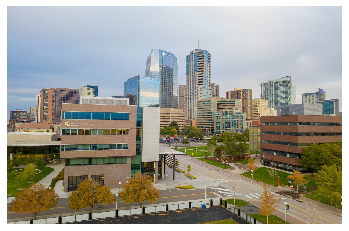

In [5]:
por.show_original()

In [6]:
por.split_image()

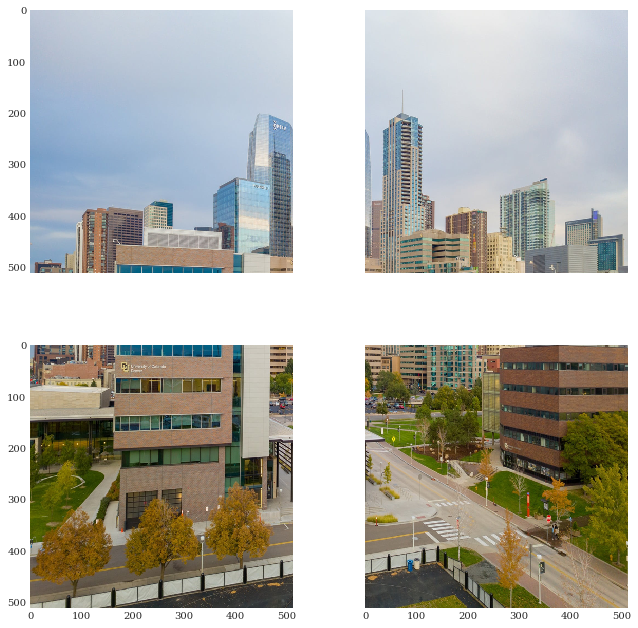

In [7]:
por.show_image_blocks()
por.save_image_blocks(r'C:\Users\Henok\OneDrive\Research\Thesis\output\512')

In [8]:
new_input, label = por.construct_new_input_from_blocks(block_ranking_measure=Measure.ENTROPY)

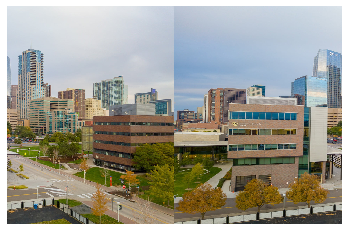

'1\\1_Entropy_512x512_reconstructed.png'

In [9]:
por.show_reconstructed_input()
por.save_reconstructed_input(measure='Entropy')

In [10]:
reference_block_minimum_entropy = np.argmin(por.ranks)
new_input, label = por.construct_new_input_from_blocks(block_ranking_measure=Measure.MI, reference_block_index=reference_block_minimum_entropy)

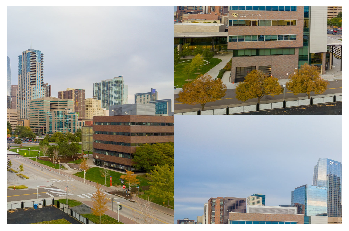

In [11]:
por.save_reconstructed_input(measure='MI')
por.show_reconstructed_input()

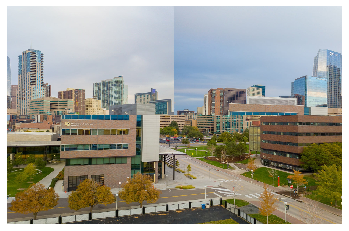

In [12]:
reference_block_minimum_entropy = np.argmin(por.ranks)
new_input, label = por.construct_new_input_from_blocks(block_ranking_measure=Measure.JE, reference_block_index=reference_block_minimum_entropy)
por.save_reconstructed_input(measure='JE')
por.show_reconstructed_input()

# POR Training pipeline - Configuration based

In [ ]:
### 1. Training Configuration

In [15]:
from deepclo.config import Config
from deepclo.models.model_factory import NeuralNet
from deepclo.pipe.dataset import ImageDataProvider

config = Config(config_file='../configurations/deepclo_train_config.ini')
print(config.model)
print(config)


b0
Config
	dataset: cifar10
	model_dir: C:\deepclo\training
	num_classes: 10
	batch_size: 8
	learning_rate: 0.001
	optimizer: adam
	loss_function: SparseCategoricalCrossentropy
	use_clo: False
	syllabus_measure: Entropy
	epochs: 100
	use_por: True
	por_measure: Entropy
	model: b0
	activation: softmax
	pooling: max
	block_shape: 8
	rank_order: 0



In [16]:
### 2. Build training, validation dataset

In [17]:
dataset = ImageDataProvider(config.dataset)
print(dataset)

 ImageDataProvider
            	Name   : cifar10
            	Train  : (50000, 32, 32, 3)
            	Test   : (10000, 32, 32, 3)
        


#### 3. Define Model

In [18]:
model = NeuralNet(config=config, input_shape=dataset.input_shape)

In [19]:
print(model)

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization[0][0]']          
                                                                                     

 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 8, 8, 144)   0           ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2b_dwconv (DepthwiseConv2  (None, 8, 8, 144)   1296        ['block2b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2b_bn (BatchNormalization  (None, 8, 8, 144)   576         ['block2b_dwconv[0][0]']         
 )                                                                                                
          

                                                                                                  
 block3b_bn (BatchNormalization  (None, 4, 4, 240)   960         ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_activation (Activation  (None, 4, 4, 240)   0           ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_s

 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block4b_se_reshape[0][0]']     
                                                                                                  
 block4b_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block4b_se_reduce[0][0]']      
                                                                                                  
 block4b_se_excite (Multiply)   (None, 2, 2, 480)    0           ['block4b_activation[0][0]',     
          

 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_se_excite (Multiply)   (None, 2, 2, 480)    0           ['block5a_activation[0][0]',     
                                                                  'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_project_conv (Conv2D)  (None, 2, 2, 112)    53760       ['block5a_se_excite[0][0]']      
                                                                                                  
 block5a_project_bn (BatchNorma  (None, 2, 2, 112)   448         ['block5a_project_conv[0][0]']   
 lization)

 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 2, 2, 112)    0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_add (Add)              (None, 2, 2, 112)    0           ['block5c_drop[0][0]',           
                                                                  'block5b_add[0][0]']            
                                                                                                  
 block6a_expand_conv (Conv2D)   (None, 2, 2, 672)    75264       ['block5c_add[0][0]']            
                                                                                                  
 block6a_expand_bn (BatchNormal  (None, 2, 2, 672)   2688        ['block6a_expand_conv[0][0]']    
 ization) 

 block6c_expand_conv (Conv2D)   (None, 1, 1, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 1, 1, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6c_expand_activation (Act  (None, 1, 1, 1152)  0           ['block6c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6c_dwconv (DepthwiseConv2  (None, 1, 1, 1152)  28800       ['block6c_expand_activation[0][0]
 D)                                                              ']                               
          

 block7a_expand_activation (Act  (None, 1, 1, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 1, 1, 1152)  10368       ['block7a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block7a_bn (BatchNormalization  (None, 1, 1, 1152)  4608        ['block7a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block7a_activation (Activation  (None, 1, 1, 1152)  0           ['block7a_bn[0][0]']             
 )        

In [20]:
model.open()

Serving 'b0.h5' at http://localhost:8080


In [7]:
model.benchmark(dataset=dataset)

2022-03-30 14:03:29,692 - NeuralNet - DEBUG - Compiling model, loss: SparseCategoricalCrossentropy, optimizer: adam
2022-03-30 14:03:29,702 - NeuralNet - DEBUG - Setting up callbacks, model_dir: C:\deepclo\training
2022-03-30 14:03:29,703 - NeuralNet - DEBUG - Model checkpoints and events: C:\deepclo\training\b0\cifar10\adam\False
2022-03-30 14:03:29,704 - NeuralNet - DEBUG - To open tensorboard run `tensorboard --logdir C:\deepclo\training\b0\cifar10\adam\False\events`
2022-03-30 14:03:29,706 - NeuralNet - INFO - Starting training benchmark, model: b0, epochs: 1...
2022-03-30 14:03:29,706 - NeuralNet - DEBUG - Config
	dataset: cifar10
	model_dir: C:\deepclo\training
	num_classes: 2
	batch_size: 8
	learning_rate: 0.001
	optimizer: adam
	loss_function: SparseCategoricalCrossentropy
	use_clo: False
	syllabus_measure: 
	epochs: 100
	use_por: False
	por_measure: Entropy
	model: b0
	activation: softmax
	pooling: max
	block_shape: 8
	rank_order: 0

C:\anaconda3\envs\clo\lib\site-packages\ten

6250/6250 [==============================] - ETA: 0s - loss: 3.5027 - acc: 0.4522
Epoch 1: saving model to C:\deepclo\training\b0\cifar10\adam\False\checkpoints\cp.ckpt-e01
6250/6250 [==============================] - 1378s 220ms/step - loss: 3.5027 - acc: 0.4522 - val_loss: 2.2538 - val_acc: 0.6476


2022-03-30 14:26:27,893 - NeuralNet - DEBUG - Execution time: 1378.2018097999971
